In [1]:
# Seed value
seed_value = 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from tensorflow.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [2]:
import time
import numpy as np
import pandas as pd
import cv2
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Layer, InputLayer, Dense, InputSpec, LSTM, Flatten, RNN, Subtract, Concatenate
from tensorflow.keras.models import Model
from tensorflow import shape, reshape
from collections import OrderedDict
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import scipy.io as sio
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r_squared

In [3]:
# Load Data from MATLAB file and process it into Pandas dataframe


data_matlab = sio.loadmat("C:\\Users\\Thomas\\Downloads\\200805-Whiskerdata\\2Hz_20seconds_freewhisk.mat")

mdata = data_matlab['data']

#print(mdata)

mdtype = mdata.dtype

ndata = {n: mdata[n][0, 0] for n in mdtype.names}

#print(mdtype.names)

xy_measured = ndata['xy_meas_50Hz'][0]

theta_command = ndata['theta_cmd'][0]

theta_measured = ndata['theta_meas_50Hz'][0]

## Seems to be structured Head[Row[Arc[Whisker]]]

# Row-wise extraction

#XY Whisker Data: 4 rows * 6 arcs. 24 Samples per theta measured, 240 per theta command

xy_whisker_data = pd.DataFrame()

for i in range(0,len(xy_measured)):
    for j in range(0,len(xy_measured[i])):
        column_name = 'Row {row}, Arc {arc}'.format(row = i+1, arc = j+1)
        column_data = xy_measured[i][j]
        xy_whisker_data[column_name] = column_data

print("XY: \n", xy_whisker_data)

theta_command_whisker_data = pd.DataFrame()

for i in range(0,len(theta_command)):
    column_name = 'Row {row}'.format(row = i+1)
    column_data = theta_command[i]#.repeat(10)
    theta_command_whisker_data[column_name] = column_data

print("Theta Command: \n", theta_command_whisker_data)

theta_measured_whisker_data = pd.DataFrame()

for i in range(0,len(theta_measured)):
    column_name = 'Row {row}'.format(row = i+1)
    column_data = theta_measured[i]
    theta_measured_whisker_data[column_name] = column_data

print("Theta Measured: \n", theta_measured_whisker_data)

# Theta Command repeated 10 times, to fill out rows to match XY and Theta Measured
# Theta Measured would seem to apply to only 1 whisker?
# XY is unfiltered, raw Hall Effect data

XY: 
       Row 1, Arc 1  Row 1, Arc 2  Row 2, Arc 1  Row 2, Arc 2  Row 3, Arc 1  \
0         0.003199     -0.001866      0.000224  0.000000e+00     -0.000935   
1        -0.003999     -0.001866      0.000449 -4.488281e-04     -0.002338   
2        -0.007465     -0.002933      0.005947  3.366211e-04     -0.004208   
3        -0.020528     -0.002666      0.024798 -1.346484e-03     -0.005611   
4        -0.043989      0.002399      0.030071 -7.742285e-03     -0.000935   
...            ...           ...           ...           ...           ...   
2195      0.015996      0.005865     -0.023339 -5.161524e-03     -0.006546   
2196     -0.010131     -0.006665     -0.010884 -3.590625e-03      0.034601   
2197      0.001600     -0.006665      0.005610  2.328306e-11      0.031795   
2198      0.060519     -0.007198     -0.027491  4.263867e-03      0.031795   
2199      0.067184     -0.005332     -0.033774  1.795313e-03      0.017300   

      Row 3, Arc 2  Row 4, Arc 1  Row 4, Arc 2  
0       

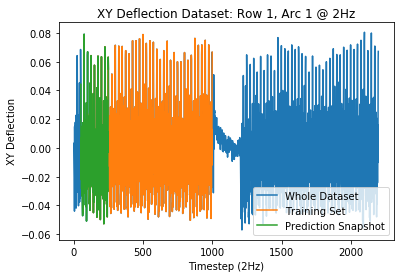

In [28]:
plt.plot(xy_whisker_data['Row 1, Arc 1'], label = 'Whole Dataset')
plt.plot(xy_whisker_data['Row 1, Arc 1'][100:1000], label = 'Training Set')
plt.plot(xy_whisker_data['Row 1, Arc 1'][50:250], label = 'Prediction Snapshot')
plt.title("XY Deflection Dataset: Row 1, Arc 1 @ 2Hz")
plt.xlabel('Timestep (2Hz)')
plt.ylabel('XY Deflection')

plt.legend(loc = 'lower right')

In [5]:
# Data Preprocessing - reshaping into several different variants, both overlapping and non-overlapping

data_shape = (900,1,1)
feature_range = (0,1)
data_start = 100
data_end = 1000

batch_size = 100

xy_3d = xy_whisker_data['Row 1, Arc 1'][data_start:data_end].to_numpy().reshape(data_shape)
xy_3d_val = xy_whisker_data['Row 1, Arc 2'][data_start:data_end].to_numpy().reshape(data_shape)
theta_command_3d = theta_command_whisker_data['Row 1'][data_start:data_end].to_numpy().reshape(data_shape)
theta_actual_3d = theta_measured_whisker_data['Row 1'][data_start:data_end].to_numpy().reshape(data_shape)

#print(xy_3d.shape, xy_3d.dtype)
#print(theta_command_3d.shape, theta_command_3d.dtype)
#print(theta_actual_3d.shape, theta_actual_3d.dtype)

# MinMaxScaling - seperate scalers used to allow descaling for predictions

xy_3d_scaler = MinMaxScaler(feature_range=feature_range)
xy_3d_scaled = xy_3d_scaler.fit_transform(xy_whisker_data['Row 1, Arc 1'][data_start:data_end].to_numpy().reshape(-1,1))

xy_3d_scaled = xy_3d_scaled.reshape(data_shape)

xy_3d_val_scaler = MinMaxScaler(feature_range=feature_range)
xy_3d_val_scaled = xy_3d_val_scaler.fit_transform(xy_whisker_data['Row 2, Arc 1'][data_start:data_end].to_numpy().reshape(-1,1))

xy_3d_val_scaled = xy_3d_val_scaled.reshape(data_shape)

theta_command_scaler = MinMaxScaler(feature_range=feature_range)
theta_command_scaled = theta_command_scaler.fit_transform(theta_command_whisker_data['Row 1'][data_start:data_end].to_numpy().reshape(-1,1))

theta_command_scaled = theta_command_scaled.reshape(data_shape)

#print(theta_command_scaled.shape)


# Without overlapping

xy_3d_no_overlap = []

for sample in range(0, xy_3d.shape[0], batch_size):
    
    xy_3d_no_overlap.append(xy_3d[sample:sample+batch_size])
    
print(len(xy_3d_no_overlap))
#print(xy_3d_no_overlap)


# With overlap

xy_3d_with_overlap = []

for sample in range(0, xy_3d.shape[0]-batch_size, 1):
    
    xy_3d_with_overlap.append(xy_3d[sample:sample+batch_size])
    
print(len(xy_3d_with_overlap))


# No overlap, for validation data (similar whisker)

xy_3d_val_no_overlap = []

for sample in range(0, xy_3d_val.shape[0], batch_size):
    
    xy_3d_val_no_overlap.append(xy_3d_val[sample:sample+batch_size])
    
print(len(xy_3d_val_no_overlap))

# No overlap, scaled

xy_3d_scaled_data = []

for sample in range(0, xy_3d_scaled.shape[0], batch_size):
    
    xy_3d_scaled_data.append(xy_3d_scaled[sample:sample+batch_size])
    
print(len(xy_3d_scaled_data))
#print(xy_3d_scaled.shape)

# No overlap, scaled, for validation data

xy_3d_val_scaled_data = []

for sample in range(0, xy_3d_val_scaled.shape[0], batch_size):
    
    xy_3d_val_scaled_data.append(xy_3d_val_scaled[sample:sample+batch_size])
    
print(len(xy_3d_val_scaled_data))

# With overlap, scaled

xy_3d_with_overlap_scaled = []

for sample in range(0, xy_3d_scaled.shape[0]-batch_size, 1):
    
    #print(sample)
    
    xy_3d_with_overlap_scaled.append(xy_3d_scaled[sample:sample+batch_size])
    
print(len(xy_3d_with_overlap_scaled))

# No overlap, for theta command data

theta_command_data = []

for sample in range(0, theta_command_3d.shape[0], batch_size):
    
    theta_command_data.append(theta_command_3d[sample:sample+batch_size])
    
print(len(theta_command_data))

# No overlap, scaled, for theta command data

theta_command_scaled_data = []

for sample in range(0, theta_command_scaled.shape[0], batch_size):
    
    theta_command_scaled_data.append(theta_command_scaled[sample:sample+batch_size])
    
print(len(theta_command_scaled_data))

9
800
9
9
9
800
9
9


In [6]:
xy_3d_scaled_data

[array([[[0.57894737]],
 
        [[0.20445344]],
 
        [[0.41902834]],
 
        [[0.29757085]],
 
        [[0.46356275]],
 
        [[0.20850202]],
 
        [[0.37044534]],
 
        [[0.39676114]],
 
        [[0.19635627]],
 
        [[0.56882591]],
 
        [[0.41093117]],
 
        [[0.10526315]],
 
        [[0.13157894]],
 
        [[0.15182186]],
 
        [[0.45546559]],
 
        [[0.74291499]],
 
        [[0.0708502 ]],
 
        [[0.34210526]],
 
        [[0.18825911]],
 
        [[0.1902834 ]],
 
        [[0.41497975]],
 
        [[0.31376518]],
 
        [[0.44331984]],
 
        [[0.8825911 ]],
 
        [[0.88866397]],
 
        [[0.49190283]],
 
        [[0.26923077]],
 
        [[0.46963563]],
 
        [[0.28137651]],
 
        [[0.50809717]],
 
        [[0.21052631]],
 
        [[0.40688259]],
 
        [[0.4271255 ]],
 
        [[0.19635627]],
 
        [[0.548583  ]],
 
        [[0.48987854]],
 
        [[0.17206477]],
 
        [[0.16801619]],
 
        [[0.

In [7]:
# Variational Autoencoder



In [8]:
class Representation(tf.keras.layers.Layer):
    
    def __init__(self, initialiser, **kwargs):
        super().__init__(**kwargs)
        
        self.input_layer = tf.keras.layers.LSTM(5, activation = 'tanh', recurrent_activation = 'hard_sigmoid', return_sequences = True, dynamic = True, dtype = 'float64', kernel_initializer = initialiser, recurrent_initializer = initialiser)
        #self.hidden1 = tf.keras.layers.LSTM(5, activation = 'tanh', recurrent_activation = 'hard_sigmoid', return_sequences = True, dynamic = True, dtype = 'float64', kernel_initializer = initialiser, recurrent_initializer = initialiser)
        #self.hidden2 = tf.keras.layers.LSTM(5, activation = 'tanh', recurrent_activation = 'hard_sigmoid', return_sequences = True, dynamic = True, dtype = 'float64', kernel_initializer = initialiser, recurrent_initializer = initialiser)
        self.output_layer = tf.keras.layers.LSTM(1, activation = 'tanh', recurrent_activation = 'hard_sigmoid', return_sequences = True, dynamic = True, dtype = 'float64', kernel_initializer = initialiser, recurrent_initializer = initialiser)
        
    def call(self, inputs):
    
        x = self.input_layer(inputs)
        #x = self.hidden1(x)
        #x = self.hidden2(x)
        x = self.output_layer(x)
        
        return x

In [9]:
# The Predictive Model - stacked LSTM and error units, similar to Cox et al. 2016

class WhiskerPredictive(tf.keras.Model):
    
    def __init__(self, stack_size, initialiser, **kwargs):
        super().__init__(**kwargs)
        
        self.first_run = True
        self.stack_size = stack_size
        
        self.ground_truth = None
        self.command = None
        
        self.representations = [Representation(initialiser = initialiser) for layer in range(self.stack_size)]
        #self.representations = [tf.keras.layers.LSTM(1, activation = 'tanh', recurrent_activation = 'hard_sigmoid', return_sequences = True, dynamic = True, dtype = 'float64', kernel_initializer = initialiser, recurrent_initializer = initialiser) for layer in range(self.stack_size)]
        #self.representations = [tf.keras.layers.SimpleRNN(1, activation = 'linear', return_sequences = True, dynamic = True, dtype = 'float64', kernel_initializer = initialiser, recurrent_initializer = initialiser) for layer in range(self.stack_size)]
        self.predictions = [tf.keras.layers.Dense(1, activation = 'linear', dtype = 'float64', dynamic = True, kernel_initializer = tf.keras.initializers.Ones()) for layer in range(self.stack_size)]
        self.actual = [tf.keras.layers.Dense(1, activation = 'linear', dtype = 'float64', dynamic = True, kernel_initializer = tf.keras.initializers.Ones()) for layer in range(self.stack_size+1)]
        
    def compile(self, optimiser, loss_function):
        super().compile()
        
        self.optimiser = optimiser
        self.loss_function = loss_function
        
    def call(self, ground_truth, command = None):
        
        if self.first_run == True:
        
            # Initialise representations and errors to zero
            
            # If it is the first run, the network will have never seen the sensory consequences before,
            # therefore no error will be present. Therefore, it will be taken to be 0. This will be
            # updated appropriately before the first model output is given.

            self.representation_cache = [tf.keras.backend.zeros_like(ground_truth) for layer in range(self.stack_size)]
            self.actual_cache = [tf.keras.backend.zeros_like(ground_truth) for layer in range(self.stack_size)]
            self.error_cache = [tf.keras.backend.zeros_like(ground_truth) for layer in range(self.stack_size)]
            self.prediction_cache = [tf.keras.backend.zeros_like(ground_truth) for layer in range(self.stack_size)]
            
        self.first_run = False
        
        # The command input to the top layer is the higher-level representation
        # If this is None, then it is just zeros
        
        if command is None:
        
            self.command = tf.keras.backend.zeros_like(ground_truth)
            
        else:
            
            self.command = command
        

        # Top-down pass through representations
        
        representation_input = tf.keras.layers.concatenate([self.representation_cache[-1],
                                                            self.error_cache[-1]],
                                                           dtype = 'float64')
        
        #print("Representation input: ", representation_input)
        
        self.representation_cache[-1] = self.representations[-1](representation_input)
        
        if self.stack_size > 1:
        
            for layer in reversed(range(self.stack_size-1)):

                error_output = self.error_cache[layer]
                
                prior_representation_output = self.representation_cache[layer]
                
                upper_representation_output = self.representation_cache[layer+1]

                representation_input = tf.keras.layers.concatenate([prior_representation_output, 
                                                                    upper_representation_output, 
                                                                    error_output],
                                                                   dtype = 'float64')

                representation_output = self.representations[layer](representation_input)

                self.representation_cache[layer] = representation_output
        
        
        # Calculate error, then do a bottom-up pass to feed this back up the error stack
        
        self.prediction_cache[0] = self.predictions[0](self.representation_cache[0])
        
        self.actual_cache[0] = self.actual[0](ground_truth)
        
        self.error_cache[0] = tf.keras.layers.subtract([self.actual_cache[0], 
                                                        self.prediction_cache[0]], 
                                                       dtype = 'float64')
        
        if self.stack_size > 1:
        
            for layer in range(1,self.stack_size):

                self.prediction_cache[layer] = self.predictions[layer](self.representation_cache[layer])

                self.actual_cache[layer] = self.actual[layer](self.error_cache[layer-1])

                self.error_cache[layer] = tf.keras.layers.subtract([self.actual_cache[layer], 
                                                                    self.prediction_cache[layer]], 
                                                                   dtype = 'float64')
        
            
        return self.actual_cache, self.prediction_cache
    
    
    def train(self, train_sensory, train_command, val_sensory, val_command, epochs = 21):
        
        training_loss = OrderedDict()
        
        validation_loss = OrderedDict()
        
        for epoch in range(epochs):
            
            batch_train_losses = []
            
            batch_val_losses = []
            
            print("Epoch ", epoch+1)
            
            for n_batch in range(len(train_sensory)):
                
                # Train
                
                with tf.GradientTape() as tape:
                    
                    # Gradients calculated comparing output predictions to target values.
                    # The error units thus provide an implicit measurement of performance for 
                    # weight updates
                    
                    train_actuals_out, train_predictions_out = self.call(train_sensory[n_batch], None)
                    
                    train_loss = self.loss_function(train_actuals_out, train_predictions_out)
                
                gradients = tape.gradient(train_loss, self.trainable_weights)
                
                batch_train_losses.append(np.mean(train_loss))

                self.optimiser.apply_gradients(zip(gradients, self.trainable_weights))
                
            epoch_train_loss = np.mean(batch_train_losses)

            training_loss[epoch+1] = epoch_train_loss
                
            print("Mean Training Error: {}".format(epoch_train_loss))
            
            # Validation currently not used until the algorithm is functioning properly
                
            if val_sensory is not None:
        
                for n_batch in range(len(val_sensory)):
                
                    # Validate

                    val_error_out, val_rep_out = self.call(val_sensory[n_batch], val_command[n_batch])

                    val_loss = self.loss_function(val_error_out, val_rep_out)

                    batch_val_losses.append(np.mean(val_loss.numpy().flatten()))

                epoch_val_loss = np.mean(batch_val_losses)

                validation_loss[epoch+1] = epoch_val_loss            
            
                print("Mean Validation Error: {}".format(epoch_val_loss))

        return training_loss, validation_loss
    
    def predict(self, input_sensory, theta_command):
        
        # Call the trained network repeatedly and return the output values
        
        prediction_losses = []
        
        predicted_values = []
        
        for n_batch in range(len(input_sensory)):

            _, pred_rep_out = self.call(input_sensory[n_batch], None)
            
            predicted_values.append(pred_rep_out[0])

            prediction_loss = self.loss_function(input_sensory[n_batch], pred_rep_out[0])

            prediction_losses.append(prediction_loss)
            
            #print("Input: ", input_sensory[n_batch], "Prediction: ", pred_rep_out[0])
            
        return predicted_values, prediction_losses
    
    def simple_test(self, input_sensory, theta_command, runs):
        
        # A small test routine to ensure the information is passed through the network correctly
        # (requires making activations linear first)
        
        for run in range(0, runs):
        
            test_actual_out, test_pred_out = self.call(input_sensory[run], theta_command)
            
            test_error_out = np.subtract(test_actual_out, test_pred_out) ** 2
            
            print("Output Prediction: ", test_pred_out)
            
            print("Output Actual: ", test_actual_out)
            
            print("Output Error: ", test_error_out, "\n")

# Next: 1 more core capability to add: Feed in contact data, report errors, map to known contacts
# i.e. predict contacts from where high prediction error is encountered

# Requires:

# A robust model that can distinguish contacts from non-contacts
# A 'contacts' method, for showing only when error is above a threshold

In [10]:
# Running the test routine

predictive_test = WhiskerPredictive(stack_size = 2, initialiser = tf.keras.initializers.Ones())

predictive_test.compile(optimiser=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        loss_function=tf.keras.losses.MeanAbsoluteError())


test_input = [tf.keras.backend.ones((1,1,1), dtype = 'float64')] * 5

#test_input = [tf.keras.backend.ones((1,1,1), dtype = 'float64') * 0.1, 
#              tf.keras.backend.ones((1,1,1), dtype = 'float64') * 0.2, 
#              tf.keras.backend.ones((1,1,1), dtype = 'float64') * 0.3, 
#              tf.keras.backend.ones((1,1,1), dtype = 'float64') * 0.4, 
#              tf.keras.backend.ones((1,1,1), dtype = 'float64') * 0.5]

#print("Input = ", test_input)

test_command = None

test_out = predictive_test.simple_test(input_sensory = test_input,
                                       theta_command = test_command, 
                                       runs = len(test_input))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Output Predictio

In [11]:
# Running the actual training

predictive_test = WhiskerPredictive(stack_size = 3, initialiser = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.))

predictive_test.compile(optimiser=tf.keras.optimizers.Adam(learning_rate=0.001),
                        loss_function=tf.keras.losses.MeanAbsoluteError())

history = predictive_test.train(train_sensory = xy_3d_scaled_data,
                                train_command = theta_command_scaled_data,
                                val_sensory = None,
                                val_command = None)



Epoch  1

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you

In [12]:
history[0].values()

def unpack_values(dictionary):
    
    list_out = []
    
    for value in dictionary.values():
        
        list_out.append(value)
        
    return list_out

history_train = unpack_values(history[0])
history_val = unpack_values(history[1])

Text(0, 0.5, 'Mean Absolute Error')

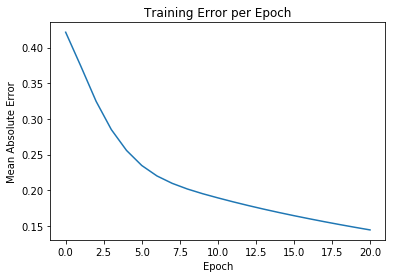

In [13]:
plt.plot(history_train)
plt.plot(history_val)

plt.title("Training Error per Epoch")

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')

In [14]:
train_derivative = []

for i in range(1,len(history_train)):
    
    train_derivative.append(history_train[i] - history_train[i-1])
    
print(np.max(train_derivative))

-0.003690164950158864


In [15]:
# Process contact data in the same way as the free whisking data above

data_matlab = sio.loadmat("C:\\Users\\Thomas\\Downloads\\200805-Whiskerdata\\2Hz_20seconds_contacts.mat")

mmdata = data_matlab['data']

mmdtype = mmdata.dtype

nndata = {n: mmdata[n][0, 0] for n in mmdtype.names}

xy_contacts = nndata['xy_meas_50Hz'][0]

theta_command_contacts = nndata['theta_cmd'][0]

## Seems to be structured Head[Row[Arc[Whisker]]]

# Row-wise extraction

#XY Whisker Data: 4 rows * 6 arcs. 24 Samples per theta measured, 240 per theta command

xy_contacts_data = pd.DataFrame()

for i in range(0,len(xy_contacts)):
    for j in range(0,len(xy_contacts[i])):
        column_name = 'Row {row}, Arc {arc}'.format(row = i+1, arc = j+1)
        column_data = xy_contacts[i][j]
        xy_contacts_data[column_name] = column_data

print("XY: \n", xy_whisker_data)

theta_command_contacts_data = pd.DataFrame()

for i in range(0,len(theta_command_contacts)):
    column_name = 'Row {row}'.format(row = i+1)
    column_data = theta_command_contacts[i]#.repeat(10)
    theta_command_contacts_data[column_name] = column_data

print("Theta Command: \n", theta_command_contacts_data)

xy_3d_contacts = xy_contacts_data['Row 1, Arc 1'][data_start:data_end].to_numpy().reshape(data_shape)
theta_command_3d_contacts = theta_command_contacts_data['Row 1'][data_start:data_end].to_numpy().reshape(data_shape)

# MinMaxScaling - seperate scalers used to allow descaling for predictions

xy_3d_contacts_scaler = MinMaxScaler(feature_range=feature_range)
xy_3d_contacts_scaled = xy_3d_contacts_scaler.fit_transform(xy_whisker_data['Row 1, Arc 1'][data_start:data_end].to_numpy().reshape(-1,1))

xy_3d_contacts_scaled = xy_3d_contacts_scaled.reshape(data_shape)

theta_command_contacts_scaler = MinMaxScaler(feature_range=feature_range)
theta_command_contacts_scaled = theta_command_contacts_scaler.fit_transform(theta_command_whisker_data['Row 1'][data_start:data_end].to_numpy().reshape(-1,1))

theta_command_contacts_scaled = theta_command_contacts_scaled.reshape(data_shape)

# Without overlapping, xy

xy_3d_contacts_no_overlap = []

for sample in range(0, xy_3d_contacts.shape[0], batch_size):
    
    xy_3d_contacts_no_overlap.append(xy_3d_contacts[sample:sample+batch_size])
    
# Without overlapping, with scaling, xy

xy_3d_contacts_scaled_data = []

for sample in range(0, xy_3d_contacts_scaled.shape[0], batch_size):
    
    xy_3d_contacts_scaled_data.append(xy_3d_contacts_scaled[sample:sample+batch_size])

# Without overlapping, theta command

theta_command_3d_contacts_no_overlap = []

for sample in range(0, theta_command_3d_contacts.shape[0], batch_size):
    
    theta_command_3d_contacts_no_overlap.append(theta_command_3d_contacts[sample:sample+batch_size])
    
print(len(xy_3d_contacts_no_overlap))
print(len(theta_command_3d_contacts_no_overlap))

XY: 
       Row 1, Arc 1  Row 1, Arc 2  Row 2, Arc 1  Row 2, Arc 2  Row 3, Arc 1  \
0         0.003199     -0.001866      0.000224  0.000000e+00     -0.000935   
1        -0.003999     -0.001866      0.000449 -4.488281e-04     -0.002338   
2        -0.007465     -0.002933      0.005947  3.366211e-04     -0.004208   
3        -0.020528     -0.002666      0.024798 -1.346484e-03     -0.005611   
4        -0.043989      0.002399      0.030071 -7.742285e-03     -0.000935   
...            ...           ...           ...           ...           ...   
2195      0.015996      0.005865     -0.023339 -5.161524e-03     -0.006546   
2196     -0.010131     -0.006665     -0.010884 -3.590625e-03      0.034601   
2197      0.001600     -0.006665      0.005610  2.328306e-11      0.031795   
2198      0.060519     -0.007198     -0.027491  4.263867e-03      0.031795   
2199      0.067184     -0.005332     -0.033774  1.795313e-03      0.017300   

      Row 3, Arc 2  Row 4, Arc 1  Row 4, Arc 2  
0       

In [16]:
# Predict

predictions = predictive_test.predict(input_sensory = xy_3d_scaled_data, 
                                      theta_command = theta_command_data)



-4.092555639210968


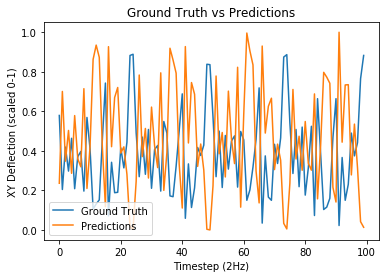

In [17]:
flat_predictions = predictions[0][0].numpy().flatten()
flat_scaled_data = np.array(xy_3d_scaled_data[0]).flatten()
flat_theta_command_scaled = np.array(theta_command_scaled_data[0]).flatten()
flat_data_no_scale = np.array(xy_3d[0]).flatten()
flat_theta_command_no_scale = np.array(theta_command_3d[0]).flatten()

plt.plot(flat_scaled_data[:100], label = 'Ground Truth')

prediction_scaler = MinMaxScaler(feature_range=feature_range)
scaled_predictions = prediction_scaler.fit_transform(flat_predictions.reshape(-1,1))

plt.plot(scaled_predictions[:100], label = 'Predictions')

plt.title("Ground Truth vs Predictions")

plt.ylabel('XY Deflection (scaled 0-1)')
plt.xlabel('Timestep (2Hz)')

plt.legend(loc = 'lower left')

prediction_scaled_r2 = r_squared(flat_scaled_data, scaled_predictions)

print(prediction_scaled_r2)

Text(0.5, 1.0, 'Original Whisker Data (blue) vs Predictions (orange), raw')

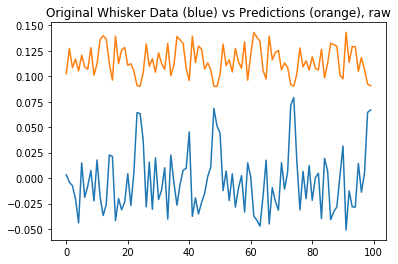

In [18]:
plt.plot(xy_whisker_data['Row 1, Arc 1'][:100])
plt.plot(flat_predictions[:100])

plt.title("Original Whisker Data (blue) vs Predictions (orange), raw")

Text(0.5, 1.0, 'Raw Predictions overlaid on Theta Command Signal (not currently used)')

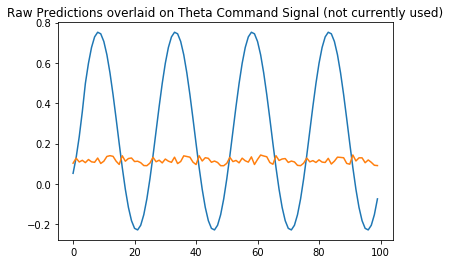

In [19]:
plt.plot(theta_command_whisker_data['Row 1'][:100])
plt.plot(flat_predictions[:100])
plt.title("Raw Predictions overlaid on Theta Command Signal (not currently used)")

Text(0.5, 1.0, 'Predictions (blue) and Errors (orange), No Contact (Free Whisking) Data')

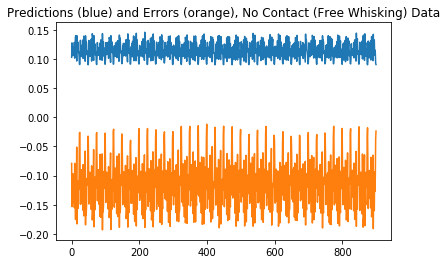

In [20]:
prediction_training_data = predictive_test.predict(input_sensory = xy_3d_scaled_data, 
                                                   theta_command = None)

flat_prediction_training_data = []

for batch in range(len(prediction_training_data[0])):
    
    flat_prediction_training_data.extend(prediction_training_data[0][batch].numpy().flatten())

#flat_prediction_training_data = prediction_training_data[0][0].numpy().flatten()

prediction_contacts = predictive_test.predict(input_sensory = xy_3d_contacts_scaled_data, 
                                              theta_command = None)

flat_prediction_contacts = []

for batch in range(len(prediction_contacts[0])):
    
    flat_prediction_contacts.extend(prediction_contacts[0][batch].numpy().flatten())

#flat_prediction_contacts = prediction_contacts[0][0].numpy().flatten()


error_no_contacts = np.subtract(xy_whisker_data['Row 1, Arc 1'][data_start:data_end].to_list(), 
                        flat_prediction_training_data)

error_contacts = np.subtract(xy_contacts_data['Row 1, Arc 1'][data_start:data_end].to_list(), 
                     flat_prediction_contacts)

plt.plot(flat_prediction_training_data)
plt.plot(error_no_contacts)

plt.title("Predictions (blue) and Errors (orange), No Contact (Free Whisking) Data")

Text(0.5, 1.0, 'Predictions (blue) and Errors (orange), Contact (Non-Free Whisking) Data')

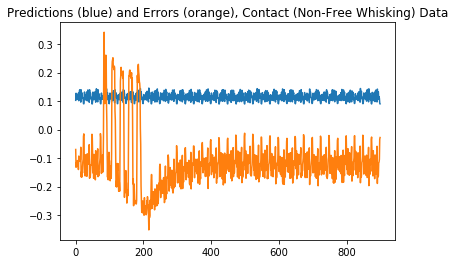

In [21]:
plt.plot(flat_prediction_contacts)
plt.plot(error_contacts)

plt.title("Predictions (blue) and Errors (orange), Contact (Non-Free Whisking) Data")

In [22]:
contact_none_difference = np.subtract(xy_contacts_data['Row 1, Arc 1'][data_start:data_end].to_list(), 
                                      xy_whisker_data['Row 1, Arc 1'][data_start:data_end].to_list())

Text(0.5, 1.0, 'Difference between no-contact and contact whisking')

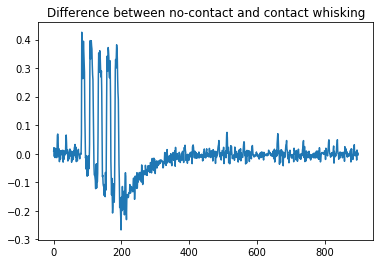

In [23]:
plt.plot(contact_none_difference)
plt.title("Difference between no-contact and contact whisking")

In [24]:
detected_error_training = np.subtract(error_no_contacts, 
                                      flat_prediction_training_data)

print(np.mean(detected_error_training))

print(np.mean(detected_error_training[50:250]))

-0.2317462153532406
-0.23170892457092038


In [25]:
detected_error_contacts = np.subtract(error_contacts, 
                                      flat_prediction_contacts)

print(np.mean(detected_error_contacts))

print(np.mean(detected_error_contacts[50:250]))

-0.23080303823734413
-0.2045395590801337


Text(0.5, 1.0, 'Error Detected for No-contact Whisking (blue) and Contact Whisking (orange)')

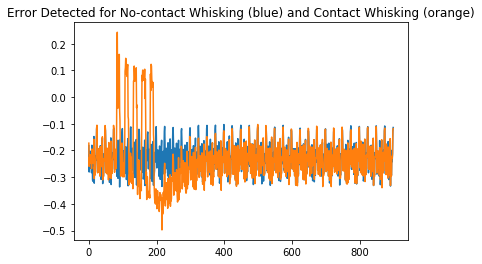

In [26]:
plt.plot(detected_error_training)
plt.plot(detected_error_contacts)

plt.title("Error Detected for No-contact Whisking (blue) and Contact Whisking (orange)")